In [2]:
from gan import GAN
from local_datasets import RayleighDataset
from torch.utils.data import DataLoader
import lightning as L
import matplotlib.pyplot as plt
import torch
import seaborn as sns
from scipy.stats import rayleigh
import numpy as np
import os

In [3]:
NUM_SAMPLES = 10000
BATCH_SIZE = 128
G_EVERY_K_STEPS = 3
MAX_EPOCHS = 100

In [4]:
model = GAN(g_every_k_steps=G_EVERY_K_STEPS)

In [5]:
train_dataset = RayleighDataset(num_samples=NUM_SAMPLES)
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, num_workers=15)
val_dataset = RayleighDataset(num_samples=NUM_SAMPLES//10)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=NUM_SAMPLES//10, num_workers=15)

In [7]:
logs_dir = os.path.join('..', 'logs', 'lightning_logs')
ckpt_path = os.path.join(logs_dir, 'version_3', 'checkpoints', 'epoch=99-step=10500.ckpt')
model = GAN.load_from_checkpoint(ckpt_path).to('cpu')
model

GAN(
  (generator): Generator(
    (model): Sequential(
      (0): Linear(in_features=100, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=32, bias=True)
      (5): ReLU()
      (6): Linear(in_features=32, out_features=1, bias=True)
    )
  )
  (discriminator): Discriminator(
    (model): Sequential(
      (0): Linear(in_features=1, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=32, bias=True)
      (3): ReLU()
      (4): Linear(in_features=32, out_features=1, bias=True)
      (5): Sigmoid()
    )
  )
)

In [ ]:
# trainer = L.Trainer(
#     max_epochs=MAX_EPOCHS, 
#     accelerator="auto",
#     default_root_dir='../logs'
# )
# trainer.fit(
#     model=model, 
#     train_dataloaders=train_dataloader,
#     val_dataloaders=val_dataloader
# )

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | generator     | Generator     | 23.3 K | train
1 | discriminator | Discriminator | 2.2 K  | train
--------------------------------------------------------
25.5 K    Trainable params
0         Non-trainable params
25.5 K    Total params
0.102     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 79/79 [00:02<00:00, 37.26it/s, v_num=3, d_loss=0.693, g_loss=0.690, real_prob=0.501, fake_prob=0.502]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 79/79 [00:02<00:00, 36.92it/s, v_num=3, d_loss=0.693, g_loss=0.690, real_prob=0.501, fake_prob=0.502]


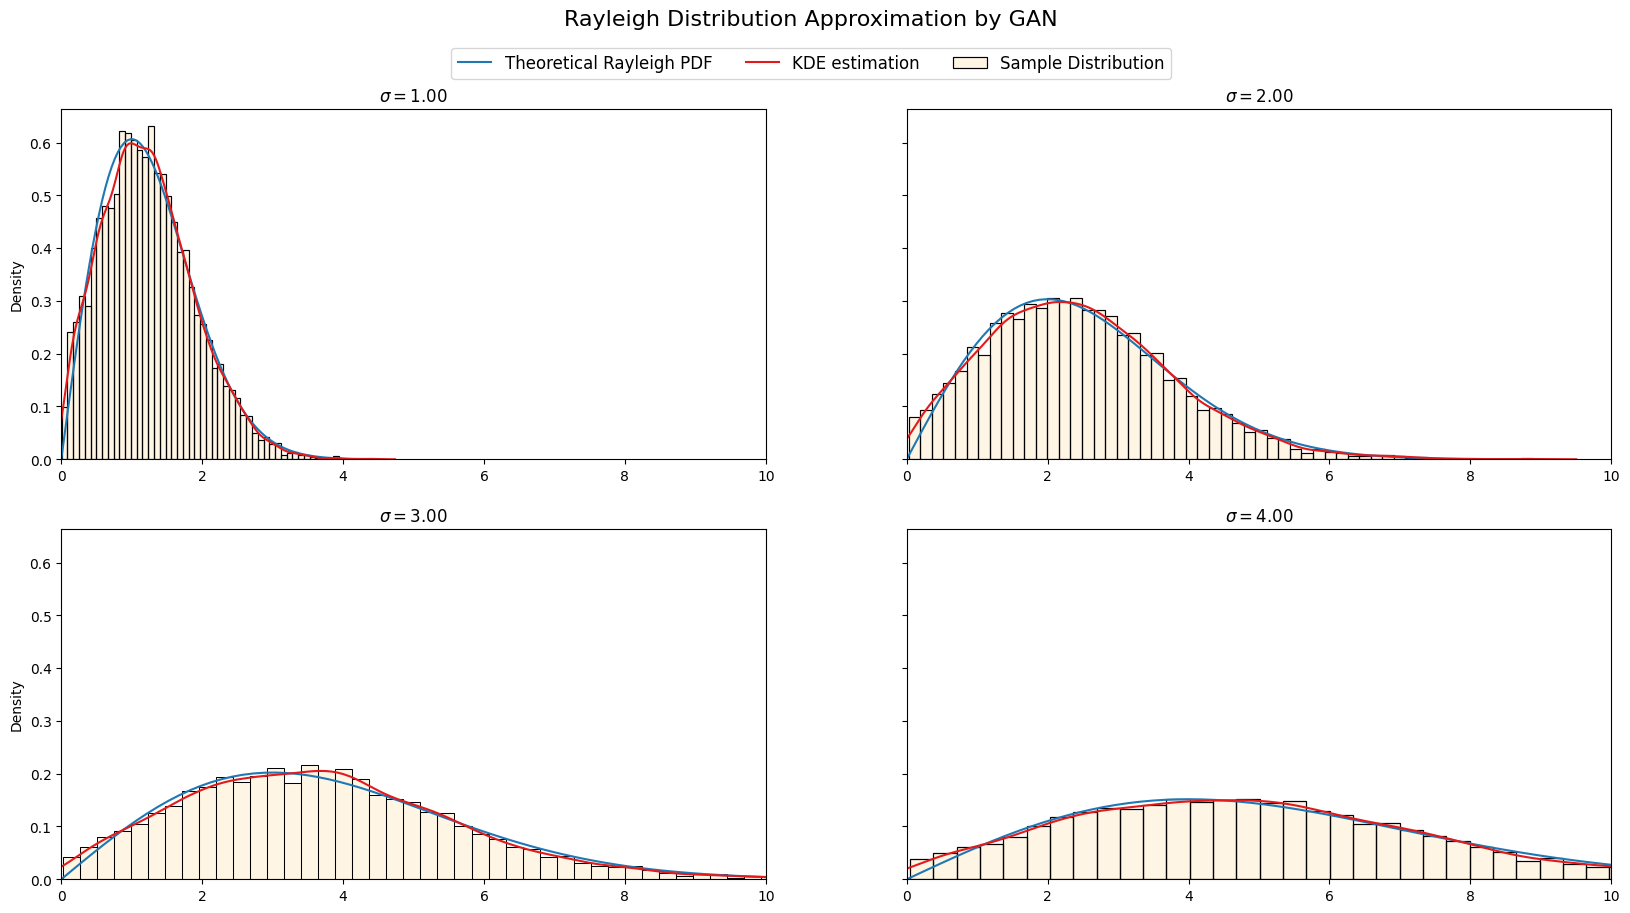

In [ ]:
def generate_distribution_subplots(num_samples, scales):
    linewidth = 1.5
    with torch.no_grad():
        fig, axes = plt.subplots(
            len(scales) // 2,
            2,
            figsize=(20, 5 * len(scales) // 2),
            sharey=True,
            # sharex=True,
        )
        if len(scales) == 1:
            axes = [axes]
        else:
            axes = axes.flatten()

        for i, scale in enumerate(scales):
            z = torch.randn(num_samples, model.latent_dim)
            generated_samples = scale * model(z)
            x = np.linspace(0, max(generated_samples), 100)
            pdf = rayleigh.pdf(x, scale=scale)
            axes[i].plot(x, pdf, "#1f78b4", linewidth=linewidth)
            # axes[i].set_label(rf"Theoretical Rayleigh PDF ($\sigma = {scale:.2f}$)")
            sns.histplot(
                generated_samples.numpy().flatten(),
                stat="density",
                kde=False,
                # label="Sample Distribution",
                ax=axes[i],
                color="orange",
                alpha=0.1,
            )
            sns.kdeplot(
                generated_samples.numpy().flatten(),
                color="#e31a1c",
                # label='KDE estimation',
                ax=axes[i],
                linewidth=linewidth,
                # fill=True,
            )
            # axes[i].legend()
            axes[i].set_title(rf"$\sigma = {scale:.2f}$")
            axes[i].set_xlim([0, 10])

        fig.suptitle("Rayleigh Distribution Approximation by GAN", fontsize=16)
        fig.legend(
            labels=[
                "Theoretical Rayleigh PDF",
                "KDE estimation",
                "Sample Distribution",
            ],
            loc="upper center",
            ncol=3,
            bbox_to_anchor=(0.5, 0.95),
            fontsize=12,
        )
        plt.show()


generate_distribution_subplots(
    # NUM_SAMPLES, scales=[np.random.random() * 10 for _ in range(6)]
    NUM_SAMPLES,
    scales=[i for i in range(1, 5)],
)

/tmp/ipykernel_2481/2774020648.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Group')


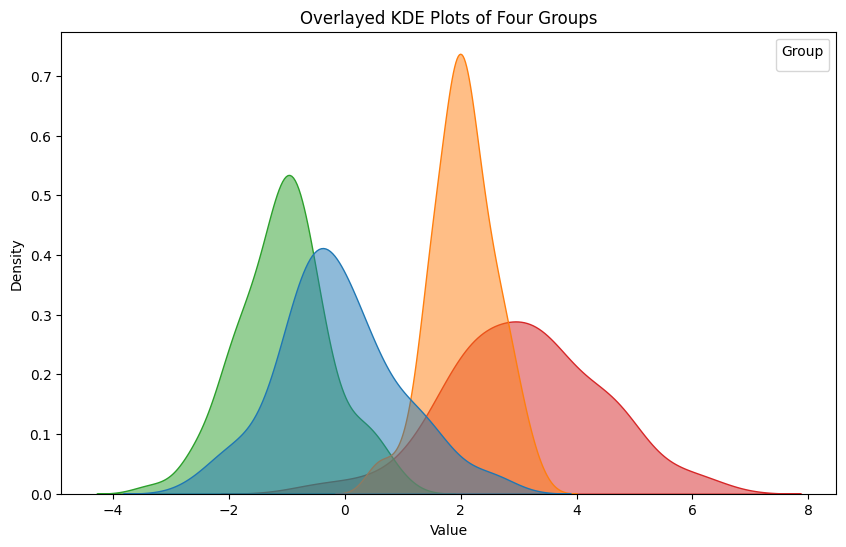

In [101]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Create sample data for four different distributions
data = {
    'value': np.concatenate([
        np.random.normal(0, 1, 100),
        np.random.normal(2, 0.5, 100),
        np.random.normal(-1, 0.8, 100),
        np.random.normal(3, 1.2, 100)
    ]),
    'group': ['A']*100 + ['B']*100 + ['C']*100 + ['D']*100
}
df = pd.DataFrame(data)

plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x='value', hue='group', fill=True, common_norm=False, alpha=0.5)
plt.title('Overlayed KDE Plots of Four Groups')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend(title='Group')
plt.show()